In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, _geoslib

In [3]:
from datetime import datetime
from math import sin, cos, tan, atan, pi, radians, degrees, asin, atan2

In [26]:
def sunpos(year, month, day, hour, minute, second, timezone, latitude, longitude):
    # https://levelup.gitconnected.com/python-sun-position-for-solar-energy-and-research-7a4ead801777
    
# Convert latitude and longitude to radians
    rlat = radians(latitude)
    rlon = radians(longitude)
# Decimal hour of the day at Greenwich
    greenwichtime = hour - timezone + minute / 60 + second / 3600
#     print(greenwichtime)
    
# Days from J2000, accurate from 1901 to 2099
    daynum = (
        367 * year
        - 7 * (year + (month + 9) // 12) // 4
        + 275 * month // 9
        + day
        - 730531.5
        + greenwichtime / 24
    )
    
#     print(daynum)
# Mean longitude of the sun
    mean_long = daynum * 0.01720279239 + 4.894967873
# Mean anomaly of the Sun
    mean_anom = daynum * 0.01720197034 + 6.240040768
# Ecliptic longitude of the sun
    eclip_long = (
        mean_long
        + 0.03342305518 * sin(mean_anom)
        + 0.0003490658504 * sin(2 * mean_anom)
    )
# Obliquity of the ecliptic
    obliquity = 0.4090877234 - 0.000000006981317008 * daynum
# Right ascension of the sun
    rasc = atan2(cos(obliquity) * sin(eclip_long), cos(eclip_long))
# Declination of the sun
    decl = asin(sin(obliquity) * sin(eclip_long))
# Local sidereal time
    sidereal = 4.894961213 + 6.300388099 * daynum + rlon
# Hour angle of the sun
    hour_ang = sidereal - rasc
    
    return degrees(decl), into_range(degrees(hour_ang),0,360)

def into_range(x, range_min, range_max):
    shiftedx = x - range_min
    delta = range_max - range_min
    return (((shiftedx % delta) + delta) % delta) + range_min

In [45]:
decl, ha = sunpos(2022,6,4,8,11,0,timezone=0,latitude=51.52,longitude=-0.01) # 51.523215, -0.015890
decl, ha

(22.442649495886144, 303.1599034932442)

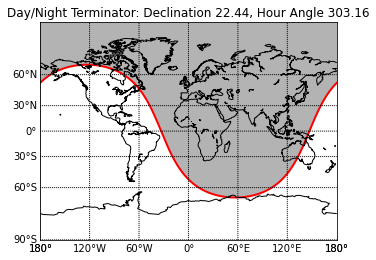

In [46]:
plot_sun_clock(decl,ha)

### Example

In [11]:
def terminator(dec,tau,nlons):
    # tau is "hour angle"
    # dec is "declination"
    dg2rad = np.pi/180.
    lons = np.linspace(-180,180,nlons)
    longitude = lons + tau
#     print(longitude)
    lats = np.arctan(-np.cos(longitude*dg2rad)/np.tan(dec*dg2rad))/dg2rad
    return lons, lats

In [4]:
# these can be computed from Julian Day.
dec = 19.73 # declination
tau = 25.89 # hour angle

In [5]:
# compute lons and lats of day/night terminator.
nlons = 1441; nlats = ((nlons-1)/2)+1
lons, lats = terminator(dec,tau,nlons)

In [6]:
lons, lats

(array([-180.  , -179.75, -179.5 , ...,  179.5 ,  179.75,  180.  ]),
 array([68.26510533, 68.22310165, 68.18056603, ..., 68.34753344,
        68.30658124, 68.26510533]))

In [7]:
nlats =721

In [8]:
# setup map projection
map = Basemap(projection='mill',lon_0=0)

In [9]:
# compute day/night terminator in projection coords
x,y = map(lons, lats)

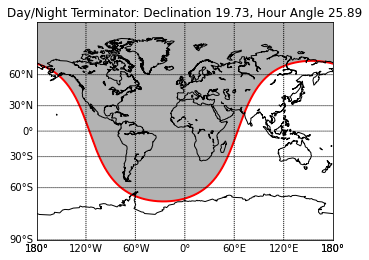

In [10]:
# plot terminator as red line
map.plot(x,y,'r',linewidth=2)

# plot coastlines, draw label meridians and parallels.
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1])

# create grid of day=1, night=0
lons2 = np.linspace(-180,180,nlons)
lats2 = np.linspace(-90,90,nlats)
lons2, lats2 = np.meshgrid(lons2,lats2)
daynight = np.ones(lons2.shape, float)
for nlon in range(nlons):
    daynight[:,nlon] = np.where(lats2[:,nlon]<lats[nlon],0,daynight[:,nlon])
x2, y2 = map(lons2,lats2)

# contour this grid with 1 contour level, specifying colors.
map.contourf(x2,y2,daynight,1,colors=['w','0.7'])
plt.title('Day/Night Terminator: Declination %4.2f, Hour Angle %4.2f' %
        (dec,tau))
plt.show()

In [11]:
def jd_from_dt(dt:datetime):
    # https://en.wikipedia.org/wiki/Position_of_the_Sun
    
    secs = (dt - datetime(1970, 1, 1)).total_seconds()
    jdn = 2440587.5 + secs / (1000.0 * 3600 * 24)
    return jdn

In [12]:


jdn=jd_from_dt(datetime.now())
jdn

2440606.825009966

In [17]:
sun_longitude(jdn)

jdn = 2440606.825009966, n = -10938.174990034197, L = 299.2762603277679, g = 16.858354552299716, lambda_ = 299.84272481594354, T = -0.2996760271242246, epsilon = 23.6732103431532, alpha = -57.936639388470546, GMST = 15.752055677003227


178.34419576657785

In [ ]:
plot_sun_clock(299,23)

In [ ]:
def terminator2(jdn, nlons=1441):
    
    nlats = int(((nlons-1)/2)+1)
    
    # tau is "hour angle"
    # dec is "declination"
    dg2rad = np.pi/180.
    lons = np.linspace(-180,180,nlons)
    
    n = jdn - 2451545.0 # 1/1/2000
    L = (280.460 + 0.9856474 * n) % 360.0
    g = (357.528 + 0.9856004 * n) % 360.0
    degtorad = 2.0 * pi / 360.0
    lambda_ = L + 1.915 * sin(g * degtorad) + 0.020 * sin(2 * g * degtorad)
    
    T = n / (365 * 100.0) # julian centuries from 2000
    # ε = 23° 26′ 21.406″ − 46.836769″ T − 0.0001831″ T2
    epsilon = 23.4392794 - 0.780612817 * T - 5.0861e-8 * T * T;
    
    longitude = lons + epsilon
#     longitude = lons + tau
#     print(longitude)
#     lats = np.arctan(-np.cos(longitude*dg2rad)/np.tan(dec*dg2rad))/dg2rad
    return lons, lats

In [14]:
# originally from https://astronomy.stackexchange.com/questions/12392/math-for-calculating-the-terrestrial-longitude-directly-under-the-sun-with-time
def sun_longitude(jdn):
    """Given time in ms since 1/1/1970, return the longitude the sun is over at that moment"""
    # https://en.wikipedia.org/wiki/Position_of_the_Sun
#     jdn = 2440587.5 + when / (1000.0 * 3600 * 24)
    n = jdn - 2451545.0 # 1/1/2000
    L = (280.460 + 0.9856474 * n) % 360.0
    g = (357.528 + 0.9856004 * n) % 360.0
    degtorad = 2.0 * pi / 360.0
    lambda_ = L + 1.915 * sin(g * degtorad) + 0.020 * sin(2 * g * degtorad)

    # https://en.wikipedia.org/wiki/Axial_tilt#Short_term
    T = n / (365 * 100.0) # julian centuries from 2000
    # ε = 23° 26′ 21.406″ − 46.836769″ T − 0.0001831″ T2
    epsilon = 23.4392794 - 0.780612817 * T - 5.0861e-8 * T * T;
    alpha = atan(cos(epsilon * degtorad) * tan(lambda_ * degtorad)) / degtorad

    # https://en.wikipedia.org/wiki/Sidereal_time
    # https://en.wikipedia.org/wiki/Hour_angle
    GMST = (18.697374558 + 24.06570982441908 * n) % 24.0
    print(f"jdn = {jdn}, n = {n}, L = {L}, g = {g}, lambda_ = {lambda_}, T = {T}, epsilon = {epsilon}, alpha = {alpha}, GMST = {GMST}")#.format(**locals())
    LHA = GMST * 360/24 + alpha;

    return LHA

In [33]:
def plot_sun_clock(dec,tau):
    # compute lons and lats of day/night terminator.
    nlons = 1441; nlats = int(((nlons-1)/2)+1)
    lons, lats = terminator(dec,tau,nlons)

    # setup map projection
    map = Basemap(projection='mill',lon_0=0)
    #map = Basemap(projection='ortho',lon_0=-105,lat_0=40)
    # compute day/night terminator in projection coords
    x,y = map(lons, lats)
    # plot terminator as red line
    map.plot(x,y,'r',linewidth=2)
    # plot coastlines, draw label meridians and parallels.
    map.drawcoastlines()
    map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
    map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1])
    # create grid of day=1, night=0
    lons2 = np.linspace(-180,180,nlons)
    lats2 = np.linspace(-90,90,nlats)
    lons2, lats2 = np.meshgrid(lons2,lats2)
    daynight = np.ones(lons2.shape, float)
    for nlon in range(nlons):
        daynight[:,nlon] = np.where(lats2[:,nlon]<lats[nlon],0,daynight[:,nlon])
    x2, y2 = map(lons2,lats2)
    # contour this grid with 1 contour level, specifying colors.
    map.contourf(x2,y2,daynight,1,colors=['w','0.7'])
    plt.title('Day/Night Terminator: Declination %4.2f, Hour Angle %4.2f' %
            (dec,tau))
    plt.show()

In [34]:
plot_sun_clock(dec,tau)

NameError: name 'dec' is not defined